# EDA (Exploratory Data Analysis) of the dataset

In this notebook, explore the Abalone dataset, by showing relevant visualizations that help understand the problem you are modelling.

Please make sure to write down your conclusions in the final notebook and to remove these intructions.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
! ls

eda.ipynb       modelling.ipynb


# Data

In [8]:
df = pd.read_csv("../data/abalone.csv")

# EDA

In [9]:
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [10]:
def profile_summary(df, n_top=5):
    """Return a concise dataframe summary: shape, dtypes, missing counts, unique counts, top values."""
    summary = []
    for c in df.columns:
        series = df[c]
        summary.append({
            "column": c,
            "dtype": str(series.dtype),
            "n_missing": int(series.isna().sum()),
            "pct_missing": float(series.isna().mean()),
            "n_unique": int(series.nunique(dropna=True)),
            "top": series.dropna().mode().iloc[0] if series.dropna().shape[0] else None,
            "top_count": int(series.dropna().value_counts().iloc[0]) if series.dropna().shape[0] else 0,
        })
    import pandas as _pd
    return _pd.DataFrame(summary).sort_values("pct_missing", ascending=False)


def missing_summary(df):
    """Return columns with missing data and counts."""
    miss = df.isna().sum()
    miss = miss[miss > 0].sort_values(ascending=False)
    return miss


def plot_numeric_distributions(df, numeric_cols=None, bins=30, figsize=(12, 8)):
    """Plot histograms and boxplots for numeric columns."""
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    n = len(numeric_cols)
    if n == 0:
        print("No numeric columns found.")
        return
    cols = min(3, n)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows * 2, cols, figsize=figsize)
    axes = np.array(axes).reshape(rows * 2, cols)
    for i, col in enumerate(numeric_cols):
        r = (i // cols) * 2
        c = i % cols
        sns.histplot(df[col].dropna(), bins=bins, ax=axes[r, c], kde=True)
        axes[r, c].set_title(f"Histogram: {col}")
        sns.boxplot(x=df[col], ax=axes[r + 1, c])
        axes[r + 1, c].set_title(f"Boxplot: {col}")
    # hide unused axes
    for j in range(i + 1, rows * cols):
        r = (j // cols) * 2
        c = j % cols
        axes[r, c].set_visible(False)
        axes[r + 1, c].set_visible(False)
    plt.tight_layout()
    plt.show()


def correlation_matrix(df, numeric_only=True, figsize=(10, 8), method='pearson'):
    """Compute and plot correlation matrix for numeric columns."""
    if numeric_only:
        df_num = df.select_dtypes(include=[np.number])
    else:
        df_num = df.copy()
    corr = df_num.corr(method=method)
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
    plt.title('Correlation matrix')
    plt.show()
    return corr


def categorical_summary(df, cat_cols=None, top_n=10):
    """Return counts for categorical columns and plot bar charts for top categories."""
    if cat_cols is None:
        cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    import pandas as _pd
    result = {}
    for c in cat_cols:
        vc = df[c].value_counts(dropna=False)
        result[c] = vc
    return result


def detect_outliers(df, col, method='iqr'):
    """Return boolean mask of outliers for a numeric column.
    method: 'iqr' or 'zscore'
    """
    series = df[col].dropna()
    if method == 'iqr':
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        mask = (df[col] < lower) | (df[col] > upper)
    else:
        from scipy import stats
        z = np.abs(stats.zscore(df[col].fillna(df[col].mean())))
        mask = z > 3
    return mask



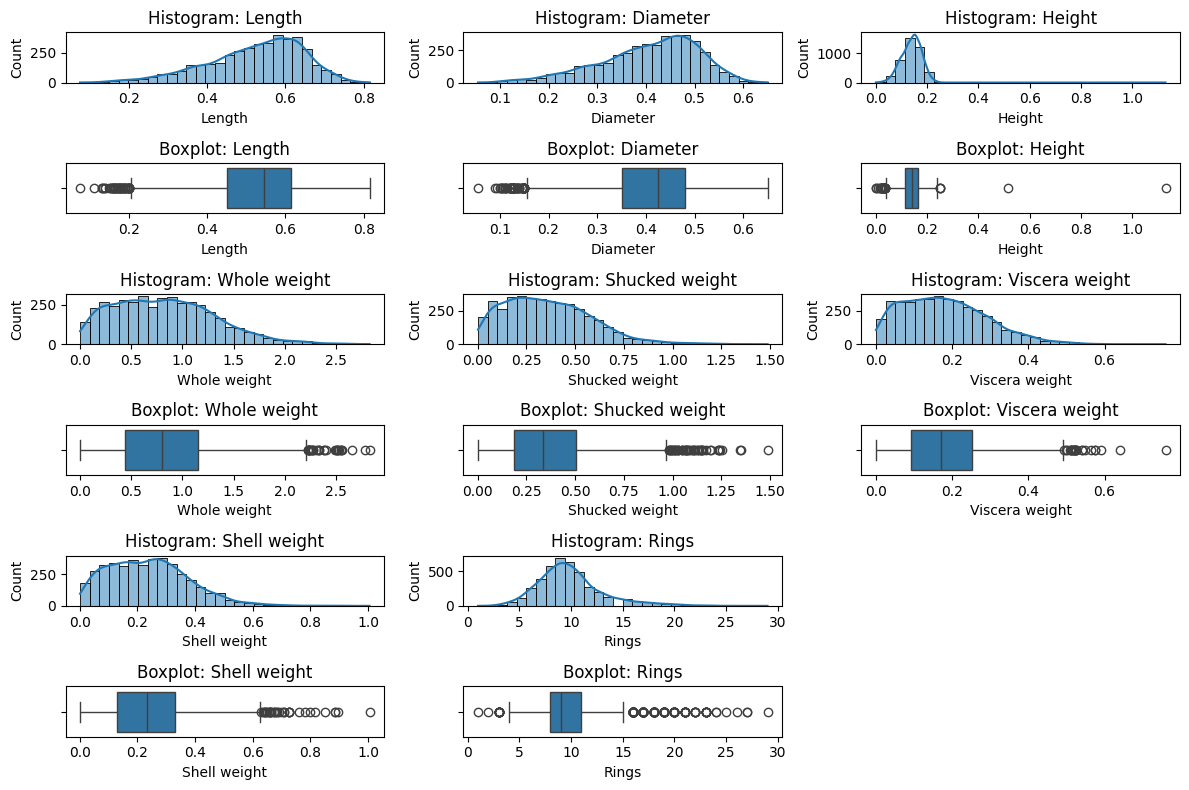

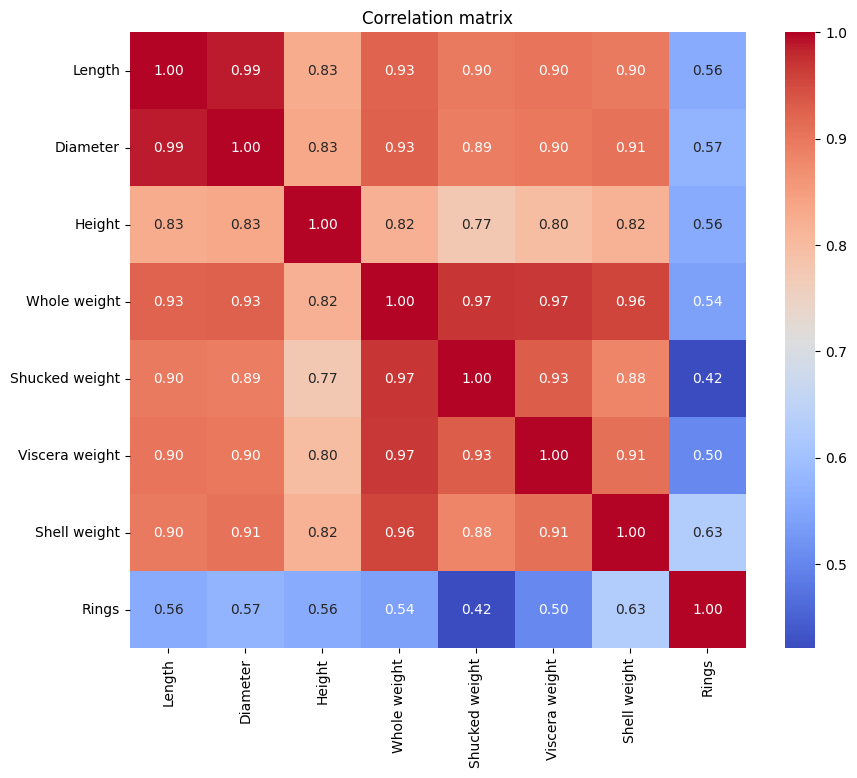

--- Sex ---
Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64

Outliers found: 278


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19
32,M,0.665,0.525,0.165,1.3380,0.5515,0.3575,0.350,18
33,F,0.680,0.550,0.175,1.7980,0.8150,0.3925,0.455,19


In [11]:
# Quick run of the EDA helpers (run in a new notebook cell after the functions are defined)

# 1) Basic profile table (top rows)
profile_df = profile_summary(df)
profile_df.head(20)

# 2) Missing values summary
missing_summary(df)

# 3) Numeric distributions (plots will be shown inline)
plot_numeric_distributions(df)

# 4) Correlation matrix (returned and plotted)
corr = correlation_matrix(df)
corr.head()   # show top of correlation table

# 5) Categorical counts (prints top categories)
cat_counts = categorical_summary(df)
for col, vc in cat_counts.items():
    print(f"--- {col} ---")
    print(vc.head(10))
    print()

# 6) Detect outliers for a numeric column (example: 'Rings' or replace with any numeric column)
out_mask = detect_outliers(df, col='Rings', method='iqr')   # change column name if needed
print('Outliers found:', out_mask.sum())
# show the rows flagged as outliers
df.loc[out_mask].head()